# Machine Learning

## Homework #6: Hidden Markov Models for speech processing

### A. The three Basic Problems for HMMs

For convenience, we use the compact notation 

$$\lambda=(A, B,  \pi)$$

to indicate the complete parameter set of the model, where $A$ is the state transition probability distribution, $B$ the emission probability distribution (which can be any distribution with parameters $\Theta$) and $\pi$ the initial state distribution.

### Problem 1: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do efficiently compute $P(O|\lambda)$?
Problem 1 is the evaluation problem, namely given a model and a sequence of observations, how do we compute the probability that the observed sequence was produced by the model. To solve this problem we use the **forward-backward algorithm**.

### Problem 2: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do we choose a corresponding state sequence $Q= q_1, q_2, ..., q_T$?
Problem 2 is the one in which we attempt to uncover the hidden part of the model, that is, the "correct" state sequence. A formal technique for finding thes best state sequence is based on dynamic programming methods, and is called **the Viterbi algorithm**.


### Problem 3: 
How do we adjust the model parameters $\lambda=(A, B,  \pi)$ to maximize the probability of the observation sequence given the model $P(O|\lambda)$?
There is no known way to analytically solve this problem. We can, however, choose $\lambda=(A, B,  \pi)$ such that $P(O|\lambda)$? is locally maximized using an iterative procedure such as the **the Baum-Welch algoritm** (or equivalently th EM algorithm).




**Reference**

Lawrence R. Rabiner "A tutorial on hidden Markov models and selected applications in speech recognition" Proceedings of the IEEE 77.2, 1989

### B. Problem description

The aim of this session is to design a HMM-based speech recogniser.

The idea is to design a **word speech recogizer**. For each word of the 7 available words we want to fit a separate N-state HMM. We represent the speech signal of a given word as a **time sequence of coded spectral feature vectors**. For each word, we have a training sequence consisting of 15 repetitions of sequences (by one or more talkers).

* The first task is to build individual word models. **This task is done by using the solution to Problem 3** to optimally estimate model parameters for each word model.

* **To understand the physical meaning of the model states, we use the solution to Problem 2** to divide each of the word training sequences into states, and then study the properties of the spectral vectors that lead to the observation ocurring in each state.

* Finally, once the set of 7 HMMs has been fitted and optimized , **recognition of unknown word is performed using the solution of Problem 1**.

The file ``words_db.pickle`` contains 15 instances of 7 different words. ``words_db['signals']`` contains the audio signals at a sampling frequency of 8 KHz, ``words_db['features']`` contains a 6 dimensions frequency feature sequences extracted from the audio signals, and ``words_db['word_labels']`` contains the transcription of the words. 

Depending on the computer hardware specifications, the signals can be reproduced using the package ``audiolab`` from ``scikits``.

### 1. Word sequences modeling


* Load the file and select the instances of the word ``apple``
* Divide the instances of the word ``apple`` into train (5) and test (10)
* Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences
* Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.



### 2. Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.
* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.
* Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

Import packages

In [95]:
%matplotlib inline

import numpy as np
import scipy
from hmmlearn.hmm import GaussianHMM
from sklearn import preprocessing
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter("default")

with open('words_db.pickle', 'rb') as handle:
    words_db = pickle.load(handle, encoding='latin1') 

Declare features and labels

In [96]:
# signals
signals=words_db['signals']
# features
features=words_db['features']
# words labels
labels=words_db['labels']
#print the different words
words = list(set(labels))
print(words)

['kiwi', 'apple', 'peach', 'orange', 'banana', 'lime', 'pineapple']


### 1. Word sequences modeling
Load the file and select the instances of the word ``apple``

Function for obtaining the train and test set for a given word

In [105]:
def getTrainTestSets(features,idx):
    #idx is the index vector identifying a given word

    numsq_train=5 # number of sequences in training set
    numsq_test=10 # number of sequences in test set
    seqlenght_train = np.empty(numsq_train) # sequence length
    x_train = np.empty([0,6])
    
    for i in range(numsq_train):
        x_train = np.append(x_train,np.transpose(features[idx[i]]),axis=0)
        seqlenght_train[i] = int(features[idx[i]].shape[1])

    seqlenght_test = np.empty(numsq_test)
    x_test = np.empty([0,6])
    y_test = np.empty([0,1])
    
    for i in range(numsq_train,15):
        x_test = np.append(x_test,np.transpose(features[idx[i]]]),axis=0)
        seqlenght_test[i-numsq_train] = int(features[idx[i]].shape[1])
        y_test = np.append(y_test,labels[idx[i]])

    return x_train,seqlenght_train,x_test,seqlenght_test,y_test

Get index vector for the word apple

In [106]:
idx_apple = [i for i in range(len(labels)) if labels[i] == 'apple']

Divide the instances of the word ``apple`` into train (5) and test (10)

In [107]:
Xtrain,lenTrain,Xtest,lenTest,yTest = getTrainTestSets(features,idx_apple)

NameError: name 'orden' is not defined

Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences

In [100]:
# Make an HMM instance and execute fit
model = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(Xtest)

# Evaluate loglikelihood
ll = model._compute_log_likelihood(Xtest)
#print('The log likelihood for the model is {}'.format(ll))


/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [101]:
# Make an HMM instance and execute fit
np.random.seed(0)
model = GaussianHMM(10, covariance_type="diag", n_iter=1000).fit(Xtrain)

# Predict the optimal sequence of internal hidden states
hidden_states = model.predict(Xtest)

# Evaluate loglikelihood
ll = model._compute_log_likelihood(Xtest)
#print('The log likelihood for the model is {}'.format(ll))

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.

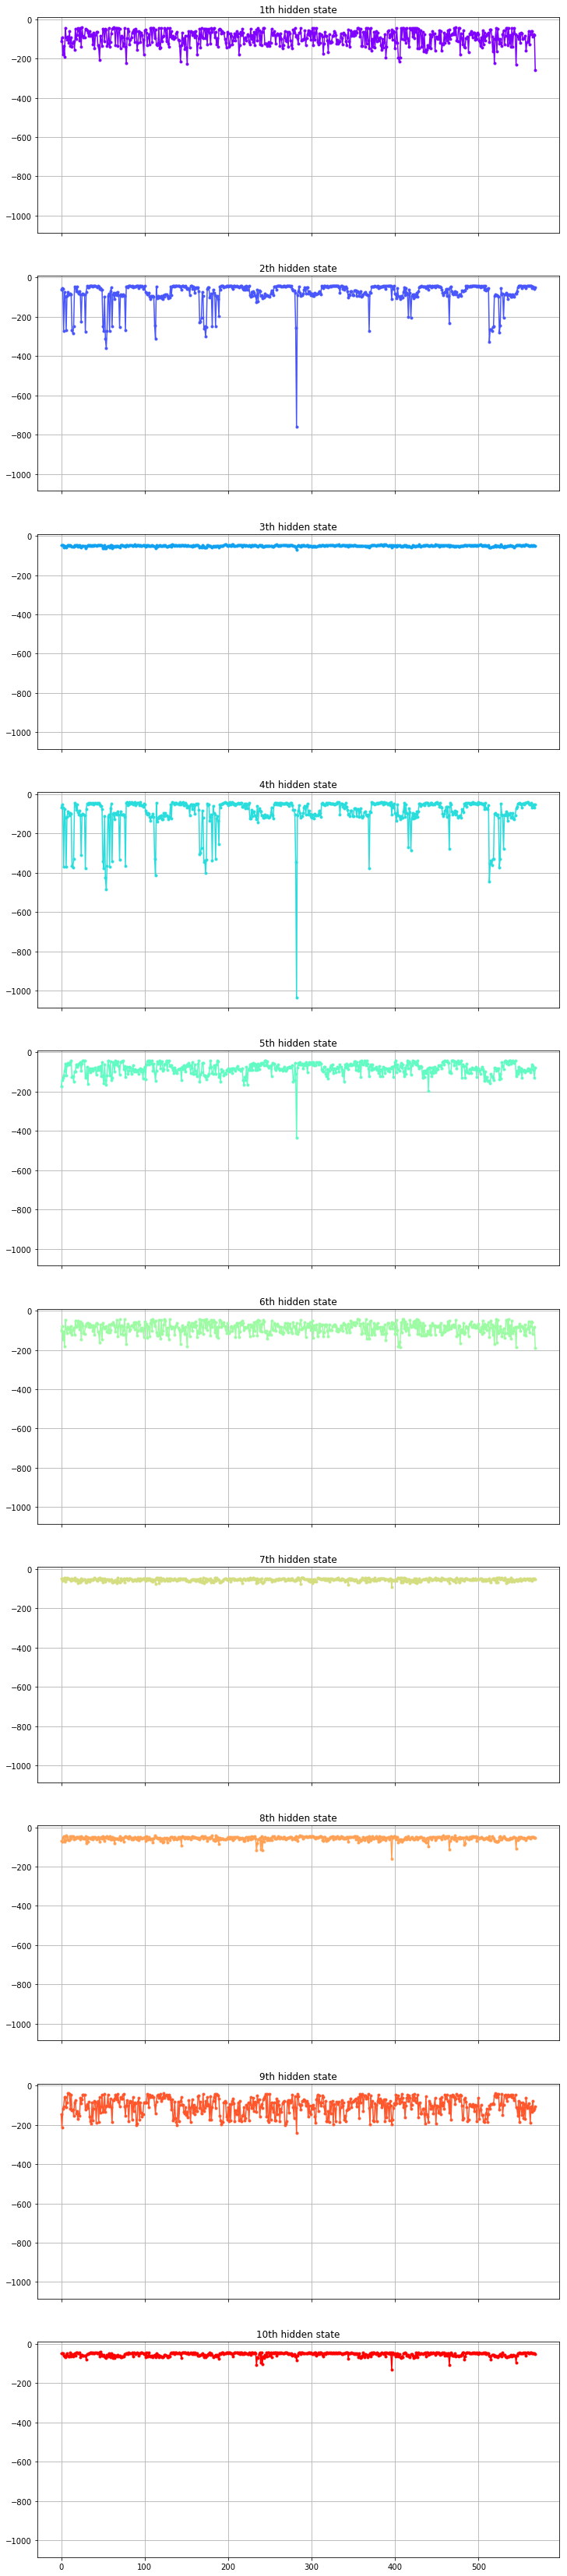

In [102]:
from matplotlib import cm, pyplot as plt

fig, axs = plt.subplots(model.n_components, figsize = (12, 60), sharex=True, sharey=True)
colours = cm.rainbow(np.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    ax.plot(ll[:,i], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i+1))
    ax.grid(True)

plt.show()

In [103]:
print("Mean and standard deviation of each hidden state\n")
for i in range(10):
    print("{0}th hidden state".format(i+1))
    print("mean = ", np.mean(ll[:,i]))
    print("SD = ", np.std(ll[:,i]))
    print()

Mean and standard deviation of each hidden state

1th hidden state
mean =  -93.7175438017
SD =  38.1856729041

2th hidden state
mean =  -80.0024342008
SD =  62.2185219546

3th hidden state
mean =  -50.5943500875
SD =  3.58868753141

4th hidden state
mean =  -96.1177319421
SD =  87.0411333638

5th hidden state
mean =  -82.3396319898
SD =  31.4296189196

6th hidden state
mean =  -88.3549558684
SD =  28.039564778

7th hidden state
mean =  -54.6901390338
SD =  6.78352988107

8th hidden state
mean =  -56.2553398344
SD =  10.6470953722

9th hidden state
mean =  -103.251509764
SD =  44.2581278909

10th hidden state
mean =  -53.263539994
SD =  9.9406765573



From the plot and the calculated means and standard deviation we observe that for 3 hidden states we obtain the lowest SDs and highest loglikelihood value.

### 2. Word classifier
We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.

Divide the instances of each word into train (5) and test (10)

In [14]:
idx_kiwi = [i for i in range(len(labels)) if labels[i] == 'kiwi']
Xtrain_kiwi,lenTrain_kiwi,Xtest_kiwi,lenTest_kiwi,yTest_kiwi = getTrainTestSets(features,idx_kiwi)
 
idx_orange = [i for i in range(len(labels)) if labels[i] == 'orange']
Xtrain_orange,lenTrain_orange,Xtest_orange,lenTest_orange,yTest_orange = getTrainTestSets(features,idx_orange)

idx_banana = [i for i in range(len(labels)) if labels[i] == 'banana']
Xtrain_banana,lenTrain_banana,Xtest_banana,lenTest_banana,yTest_banana = getTrainTestSets(features,idx_banana)

idx_lime = [i for i in range(len(labels)) if labels[i] == 'lime']
Xtrain_lime,lenTrain_lime,Xtest_lime,lenTest_lime,yTest_lime = getTrainTestSets(features,idx_lime)

idx_pineapple = [i for i in range(len(labels)) if labels[i] == 'pineapple']
Xtrain_pineapple,lenTrain_pineapple,Xtest_pineapple,lenTest_pineapple,yTest_pineapple = getTrainTestSets(features,idx_pineapple)

idx_peach = [i for i in range(len(labels)) if labels[i] == 'peach']
Xtrain_peach,lenTrain_peach,Xtest_peach,lenTest_peach,yTest_peach = getTrainTestSets(features,idx_peach)

idx_apple = [i for i in range(len(labels)) if labels[i] == 'apple']
Xtrain_apple,lenTrain_apple,Xtest_apple,lenTest_apple,yTest_apple = getTrainTestSets(features,idx_apple)

(563, 6)
(1075, 6)
(720, 6)
(575, 6)
(777, 6)
(897, 6)
(569, 6)


Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.

In [81]:
# Make an HMM instance and execute fit for each word
np.random.seed(1)

model_kiwi = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_kiwi)
model_orange = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_orange)
model_banana = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_banana)
model_lime = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_lime)
model_pineapple = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_pineapple)
model_peach = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_peach)
model_apple = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain_apple)

Xtest= np.vstack((Xtest_kiwi,Xtest_orange,Xtest_banana,Xtest_lime,Xtest_pineapple,Xtest_peach,Xtest_apple))
y_test =  np.concatenate((yTest_kiwi,yTest_orange,yTest_banana,yTest_lime,yTest_pineapple,yTest_peach,yTest_apple), axis=0)

# Evaluate loglikelihood
ll_kiwi = model_kiwi._compute_log_likelihood(Xtest)
ll_orange = model_orange._compute_log_likelihood(Xtest)
ll_banana = model_banana._compute_log_likelihood(Xtest)
ll_lime = model_lime._compute_log_likelihood(Xtest)
ll_pineapple = model_pineapple._compute_log_likelihood(Xtest)
ll_peach = model_peach._compute_log_likelihood(Xtest)
ll_apple = model_apple._compute_log_likelihood(Xtest)

# Length of each sequence in Xtest for every word
n_kiwi = int((len(Xtest_kiwi)+1)/10)
n_orange = int((len(Xtest_orange)+1)/10)
n_banana = int((len(Xtest_banana)+1)/10)
n_lime = int((len(Xtest_lime)+1)/10)
n_pineapple = int((len(Xtest_pineapple)+1)/10)
n_peach = int((len(Xtest_peach)+1)/10)
n_apple = int((len(Xtest_apple)+1)/10)

# Set size of log likelihood lists
ll_kiwi_1 = np.zeros(70)
ll_orange_1 = np.zeros(70)
ll_banana_1 = np.zeros(70)
ll_lime_1 = np.zeros(70)
ll_pineapple_1 = np.zeros(70)
ll_peach_1 = np.zeros(70)
ll_apple_1 = np.zeros(70)

# Calculate log likelihood for 3 hidden states
for i in range(len(y_test)):
    if(i<10):
        ll_kiwi_1[i] = sum(ll_kiwi[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_orange_1[i] = sum(ll_orange[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_banana_1[i] = sum(ll_banana[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_lime_1[i] = sum(ll_lime[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_pineapple_1[i] = sum(ll_pineapple[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_peach_1[i] = sum(ll_peach[i*n_kiwi:(i+1)*n_kiwi,2])
        ll_apple_1[i] = sum(ll_apple[i*n_kiwi:(i+1)*n_kiwi,2])
    
    elif(10<=i<20):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+(i-10)*n_orange:10*n_kiwi+(i-9)*n_orange,2])
    
    elif(20<=i<30):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+10*n_orange+(i-20)*n_banana:10*n_kiwi+10*n_orange+(i-19)*n_banana,2])

    elif(30<=i<40):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+10*n_orange+10*n_banana+(i-30)*n_lime:10*n_kiwi+10*n_orange+10*n_banana+(i-29)*n_lime,2])

    elif(40<=i<50):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-40)*n_pineapple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+(i-39)*n_pineapple,2])
    
    elif(50<=i<60):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-50)*n_peach:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+(i-49)*n_peach,2])
    
    elif(60<=i<70):
        ll_kiwi_1[i] = sum(ll_kiwi[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_orange_1[i] = sum(ll_orange[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_banana_1[i] = sum(ll_banana[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_lime_1[i] = sum(ll_lime[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_pineapple_1[i] = sum(ll_pineapple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_peach_1[i] = sum(ll_peach[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        ll_apple_1[i] = sum(ll_apple[10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-60)*n_apple:10*n_kiwi+10*n_orange+10*n_banana+10*n_lime+10*n_pineapple+10*n_peach+(i-59)*n_apple,2])
        
ll_matrix = np.column_stack((ll_kiwi_1,ll_orange_1,ll_banana_1,ll_lime_1,ll_pineapple_1,ll_peach_1,ll_apple_1))

word_list = ['kiwi','orange','banana','lime','pineapple','peach','apple']

y_pred = np.empty([0,1])
for i in range(len(ll_matrix)):
    idx = np.argmax(ll_matrix[i,:], axis=0)
    y_pred = np.append(y_pred,word_list[idx])

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

In [82]:
print('Classification report:')
print(classification_report(y_test, y_pred))

print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

missed = (y_pred != y_test)
print('Test accuracy: %.2f percent' % (100 * (1 - np.mean(missed))))

Classification report:
             precision    recall  f1-score   support

      apple       0.36      0.50      0.42        10
     banana       0.00      0.00      0.00        10
       kiwi       0.00      0.00      0.00        10
       lime       0.32      1.00      0.49        10
     orange       0.00      0.00      0.00        10
      peach       0.42      1.00      0.59        10
  pineapple       0.00      0.00      0.00        10

avg / total       0.16      0.36      0.21        70

Confusion matrix:
[[ 5  0  0  4  0  1  0]
 [ 1  0  0  8  0  0  1]
 [ 7  0  0  0  0  3  0]
 [ 0  0  0 10  0  0  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0 10  0]
 [ 1  0  0  9  0  0  0]]
Test accuracy: 35.71 percent


/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
# Make an HMM instance and execute fit for each word
Xtrain = np.concatenate([Xtrain_kiwi, Xtrain_orange, Xtrain_banana, Xtrain_lime, Xtrain_pineapple, Xtrain_peach, Xtrain_apple])
lengthsTrain = [len(Xtrain_kiwi), len(Xtrain_orange), len(Xtrain_banana), len(Xtrain_lime), len(Xtrain_pineapple), len(Xtrain_peach), len(Xtrain_apple)]

np.random.seed(0)
model = GaussianHMM(3, covariance_type="diag", n_iter=1000).fit(Xtrain,lengthsTrain)

Xtest= np.concatenate([Xtest_kiwi,Xtest_orange,Xtest_banana,Xtest_lime,Xtest_pineapple,Xtest_peach,Xtest_apple])
lengthsTest = [len(Xtest_kiwi),len(Xtest_orange),len(Xtest_banana),len(Xtest_lime),len(Xtest_pineapple),len(Xtest_peach),len(Xtest_apple)]

# Evaluate loglikelihood
ll = model._compute_log_likelihood(Xtest,lengthsTest)

print(ll.shape)

/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:459: RuntimeWarning: divide by zero encountered in log
  np.log(self.startprob_),
/Users/Emilie/anaconda/envs/py3.2/lib/python3.6/site-packages/hmmlearn-0.2.0-py3.6-macosx-10.7-x86_64.egg/hmmlearn/base.py:468: R

TypeError: _compute_log_likelihood() takes 2 positional arguments but 3 were given

Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)

error=[]
mse=[]

# Perform LOO-CV
for train_index,test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GPy.models.GPRegression(X_train,y_train,kernel)
    y_pred, v_pred = model.predict(X_test)
    error.append(y_pred-y_test)
    mse.append(mean_squared_error(y_pred,y_test))

# Plot the error
error_new = np.zeros((506,1))
error_new[:,0]=error
plt.plot(error_new)

# Record the overall error measures
mse = np.mean(mse)
print ("MSE: %.4f" % mse)
print("Mean error: %.4f" % np.mean(error_new))